# Searchlight for RSA
By Daniel Lindh (dnllndh@gmail.com)

Data used in this tutorial was used in:
<i>Cichy, R. M., Pantazis, D., & Oliva, A. (2016). Similarity-based fusion of MEG and fMRI reveals spatio-temporal dynamics in human cortex during visual object recognition. Cerebral Cortex, 26(8), 3563-3579.</i>

In this tutorial we will load a publically available fMRI data set for one participant. In this data set subjects passively viewed 118 images (see [project page](https://userpage.fu-berlin.de/rmcichy/fusion_project_page/main.html), where 27 images were animate and 91 were non-animate. Using RSA we will test an "animate" model to see which voxels most correspond to animate category. 

1. We get the searchlight centers with the corresponding neighboring voxels 
2. Get an RDM for each voxel
3. Evaluate each RDM against the animate/non-animate model
4. Plot results


On top of using rsatoolbox, this tutorial also make use of the following:
* numpy 1.18.1
* matplotlib 3.1.3
* nilearn 0.6.2
* pandas 1.0.1
* seaborn 0.10.0
* nibabel 3.1.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from glob import glob
import rsatoolbox
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight  

%matplotlib inline

In [2]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM
    
    Args:
        RDM 2Darray: squareform RDM
    
    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [3]:
import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

## Load data

Download Cichy's fMRI data (subject 2) grabbed from [here](http://wednesday.csail.mit.edu/MEG2_fMRI_Clear_Data/), unpack the file and change "data_folder" below to the appropriate folder path

This particular data set consist of one img-file per volume, so we need to loop over each file and add them to our data-array

In [4]:
# set this path to wherever you saved the folder containing the img-files
data_folder = 'rsatoolbox_demos/Cichy16_subj02'

image_paths = list(glob(f"{data_folder}/con_*.img"))
image_paths.sort()

# load one image to get the dimensions and make the mask
tmp_img = nib.load(image_paths[0])
# we infer the mask by looking at non-nan voxels
mask = ~np.isnan(tmp_img.get_fdata())
x, y, z = tmp_img.get_fdata().shape

# loop over all images
data = np.zeros((len(image_paths), x, y, z))
for x, im in enumerate(image_paths):
    data[x] = nib.load(im).get_fdata()

# only one pattern per image
image_value = np.arange(len(image_paths))

#print(image_paths)
print('Shape of mask:', mask.shape)
print('Shape of data:', data.shape)

Shape of mask: (53, 63, 46)
Shape of data: (118, 53, 63, 46)


### 1. Get searchlight centers and neighbors

In this example we allow neighboring voxels to be 5 voxels away from the central voxel. In order for it to be a proper center at least 50% of the neighboring voxels needs to be within the brain mask (threshold=0.5) 

In [5]:
centers, neighbors = get_volume_searchlight(mask, radius=3, threshold=0.5)

Finding searchlights...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61044/61044 [00:06<00:00, 10119.47it/s]


Found 58636 searchlights


### 2. Get an RDM for each voxel

In [6]:
# reshape data so we have n_observastions x n_voxels
data_2d = data.reshape([data.shape[0], -1])
data_2d = np.nan_to_num(data_2d)
print('New shape of data:', data_2d.shape)

# Get RDMs
SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation')

New shape of data: (118, 153594)


Calculating RDMs...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


In [7]:
print(SL_RDM.n_rdm, 'searchlight centres')
# print(SL_RDM[0])

58636 searchlight centres


### 3. Load animal model and evaluate

Our animate model has a 0 wherever both pair-wise comparisons are animals and otherwise 1.

In [8]:
# Load animal model
an_labels = np.load('rsatoolbox_demos/118_images_files/118_animate_labels.npy')
an_RDM = np.load('rsatoolbox_demos/118_images_files/118_animate_RDM.npy')
an_model = ModelFixed('Animate RDM', upper_tri(an_RDM))

['Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Animate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Animate' 'Animate' 'Inanimate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Animate' 'Animate' 'Inanimate'
 'Animate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Animate'
 'Inanimate' 'Animate' 'Inanimate' 'Animate' 'Inanimate' 'Inanimate'
 'Inanimate' 'Animate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate'
 'Animate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Animate' 'Inanimate' 'Animate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Animate' 'Animate' 'Inanimate'
 'Inanimate' 'Animate' 'Inanimate' 'Inanimate' 'Animate' 'Inanimate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Inanimate' 'Animate'
 'Inanimate' 'Inanimate' 'Animate' 'Inanimate' 'Animate' 'Inanimate'
 'Inanimate' 'Inanimate' 'Inanimate' 'Animate' 'Inanimate' 'Inanimate'
 'Inanimate' 'Inanimate' 'Animate' 'Inanimate' 'Inanimate' 'Inanimate'
 'Inanimate' 'Animate'

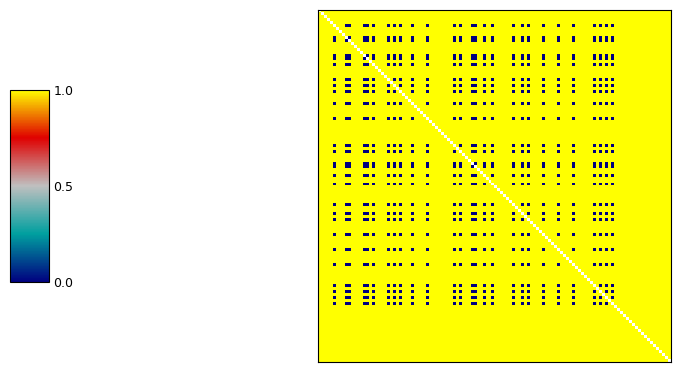

In [9]:
print(an_labels)
#print(an_model.rdm_obj)
rsatoolbox.vis.rdm_plot.show_rdm(an_model.rdm_obj, show_colorbar='figure', cmap='classic',figsize=(10,10));

In [10]:
eval_results = evaluate_models_searchlight(SL_RDM, an_model, eval_fixed, method='spearman', n_jobs=16)

# get the evaulation score for each voxel
# We only have one model, but evaluations returns a list. Here we just grab the value within that list
eval_score = [(e.evaluations[0,0,0]) for e in eval_results]

Evaluating models for each searchlight: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58636/58636 [00:21<00:00, 2697.16it/s]


In [11]:
#print(len(eval_results))
print(eval_results[0])
print(eval_score[0])

Results for running fixed evaluation for spearman on 1 models:

Model       |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------------
Animate RDM |  0.007 ±  nan |          nan  |           nan  |

p-values are based on uncorrected t-tests
0.0069259839360340325


In [12]:
# Create a 3D array, with the size of mask, and populate it with the scores
x, y, z = mask.shape
rho_brain = np.zeros([x*y*z])
rho_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = eval_score
rho_brain = rho_brain.reshape([x, y, z])

In [13]:
print(rho_brain.shape)

(53, 63, 46)


### 4. Plot results

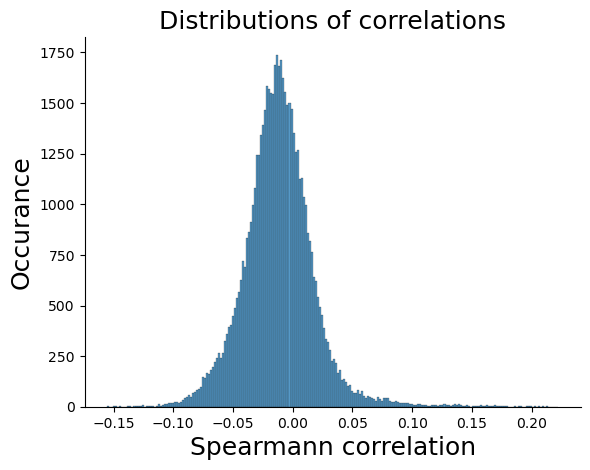

In [14]:
sns.histplot(eval_score)
plt.title('Distributions of correlations', size=18)
plt.ylabel('Occurance', size=18)
plt.xlabel('Spearmann correlation', size=18)
sns.despine()
plt.show()

Now lets plot the brain data using nilearn. We would expect the animate model to be most pronounced along the ventral visual stream.

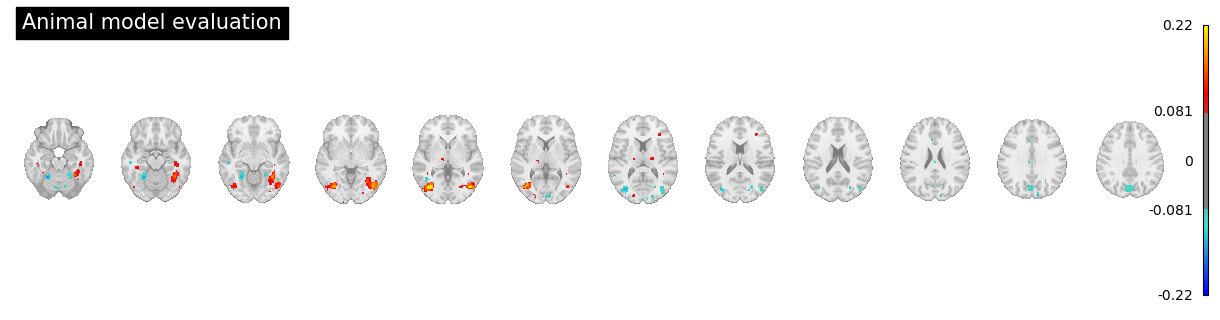

In [15]:
# lets plot the voxels above the 99th percentile
threshold = np.percentile(eval_score, 99)
plot_img = new_img_like(tmp_img, rho_brain)

cmap = RDMcolormapObject()

coords = range(-20, 40, 5)
fig = plt.figure(figsize=(12, 3))

display = plotting.plot_stat_map(
        plot_img, colorbar=True, cut_coords=coords, threshold=threshold,
        display_mode='z', draw_cross=False, figure=fig, 
        title=f'Animal model evaluation', cmap=cmap, 
        black_bg=False, annotate=False)
plt.show()